In [1]:
import requests
import base64
import pandas as pd
import IPython.display as ipd

In [2]:
client_id = 'Insert your client_id from spotify API for developers'
client_secret = 'Insert your client_secret from spotify API for developers'

In [3]:
def parse_query(query):
    return query.replace(' ', '+')

In [4]:
def get_token(client_id, client_secret):
    encoded = base64.b64encode(bytes(client_id+':'+client_secret,'utf-8'))
    token_url = 'https://accounts.spotify.com/api/token'
    params = {'grant_type':'client_credentials'}
    header = {'Authorization':'Basic '+str(encoded,'utf-8')}
    
    r = requests.post(token_url, headers=header, data=params)
    
    if r.status_code != 200:
        print('There was an error in the request', r.json())
        return None
    print(f"Valid token for {r.json()['expires_in']} seconds")
    return r.json()['access_token']

In [5]:
def get_artist_id(token, query):
    url_search = 'https://api.spotify.com/v1/search'
    header = {'Authorization':'Bearer {}'.format(token)}
    search_params = {'q':parse_query(query),
                    'type':'artist',
                    'market': 'PE'}
    
    search = requests.get(url_search, headers=header, params=search_params)
    
    if search.status_code != 200:
        print('There was an error in the request', search.json())
        return None
    
    df = pd.DataFrame(search.json()['artists']['items'])
    
    return df.sort_values(by='popularity', ascending=False).iloc[0]['id']
    

In [6]:
def get_albums(artist_id, token, return_name=False, page_limit=50, country=None):
    url = f'https://api.spotify.com/v1/artists/{artist_id}/albums'
    header = {'Authorization':f'Bearer {token}'}
    params = {'limit':page_limit,
             'offset':0,
             'country':country}
    albums = []
    r = requests.get(url, headers=header, params=params)
    
    if r.status_code != 200:
        print('There was an error in the request', r.json())
        return None
    
    if return_name:
        albums+=[(album['id'], album['name']) for album in r.json()['items']]
    else:
        albums+=[album['id'] for album in r.json()['items']]
        
    while r.json()['next']:
        
        r = requests.get(r.json()['next'], headers=header)
        
        if return_name:
            albums+=[(album['id'], album['name']) for album in r.json()['items']]
        else:
            albums+=[album['id'] for album in r.json()['items']]
    
    return albums

In [7]:
def get_tracks(album_id, token, return_name=True, page_limit=50, market=None):
    url = f'https://api.spotify.com/v1/albums/{album_id}/tracks'
    header= {'Authorization':f'Bearer {token}'}
    params={'limit':page_limit,
           'offset':0,
           'market':market}
    tracks = []
    
    r = requests.get(url, headers=header, params=params)
    
    if r.status_code != 200:
        print("There was an error in the request", r.json())
        return None
    
    if return_name:
        tracks+=[(track['id'],track['name']) for track in r.json()['items']]
    else:
        tracks+=[track['id'] for track in r.json()['items']]
    
    while r.json()['next']:
        r = requests.get(r.json()['items'], headers=header)
        if return_name:
            tracks+=[(track['id'],track['name']) for track in r.json()['items']]
        else:
            tracks+=[track['id'] for track in r.json()['items']]
    
    return tracks

In [8]:
def display_all_artist_tracks(token, artist_name):
    artist_id = get_artist_id(token, artist_name)
    albums = get_albums(artist_id, token, return_name=True, country='PE')
    print(f'{len(albums)} albums were found.')
    for i, album in enumerate(albums):
        tracks = get_tracks(album[0], token, return_name=True, market='PE')
        print(f'{i+1}) {album[1]} ({len(tracks)}) tracks')
        for e,track in enumerate(tracks):
            print(f'\t{e+1}) {track[1]}')

In [9]:
def search_for_track(token, query):
    url_search = 'https://api.spotify.com/v1/search'
    header = {'Authorization':'Bearer {}'.format(token)}
    search_params = {'q':parse_query(query),
                    'type':'track',
                    'market': 'PE'}
    
    search = requests.get(url_search, headers=header, params=search_params)
    
    if search.status_code != 200:
        print('There was an error in the request', search.json())
        return None
    
    df = pd.DataFrame(search.json()['tracks']['items'])
        
    return df.sort_values(by='popularity', ascending=False).iloc[0] 

In [10]:
def get_track_properties(track):
    preview_url = track['preview_url']
    track_name = track['name']
    track_external_url = track['external_urls']['spotify']
    artist_name = track['artists'][0]['name']
    artist_id = track['artists'][0]['id']
    
    print('Name:', track_name)
    print('Artist:', artist_name)
    #print('Preview URL:', preview_url)
    print('Link-To-Spotify:', track_external_url)
    print('Artist-id:', artist_id)

def get_album_properties(track):
    album_name = track['album']['name']
    album_release_date = track['album']['release_date']
    album_id = track['album']['id']
    album_image_url = track['album']['images'][1]['url']
    album_url = track['album']['external_urls']['spotify']
    
    print('Album-Name:', album_name)
    print('Release-Date:', album_release_date)
    print('Album-id:', album_id)
    #print('Album-image-url:', album_image_url)
    print('Link-To-Spotify:', album_url)
    img_req = requests.get(album_image_url)
    display(ipd.Image(img_req.content))

def play_preview(token, track_name):
    track = search_for_track(token, track_name)
    preview_url = track['preview_url']
    preview = requests.get(preview_url)
    
    get_track_properties(track)
    get_album_properties(track)
    
    return ipd.Audio(preview.content)

In [11]:
token = get_token(client_id, client_secret)

Valid token for 3600 seconds


Name: La Jumpa
Artist: Arcángel
Link-To-Spotify: https://open.spotify.com/track/5MxFWjuqQIsbNWbMdMdbli
Artist-id: 4SsVbpTthjScTS7U2hmr1X
Album-Name: La Jumpa
Release-Date: 2022-11-30
Album-id: 6LOhj1aK7vkGHJXtKU16PN
Link-To-Spotify: https://open.spotify.com/album/6LOhj1aK7vkGHJXtKU16PN


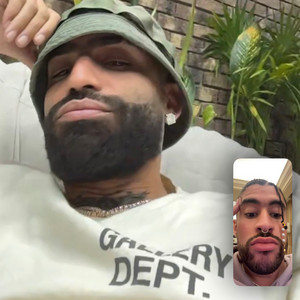

In [13]:
song = play_preview(token, 'Los Malaventurados No Lloran')
song